In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing')

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
#import gurobipy
#from gurobipy import *

pd.options.mode.chained_assignment = None

In [3]:
subreddits = ["Ask_Politics", "Askpolitics", "PoliticalDebate", "PoliticalDiscussion", "NeutralPolitics"]

data = {}
for sub in subreddits:

    input_path = f"{sub}/output/{sub}_new_preprocessing_com_rep.csv"
    data[sub] = pd.read_csv(input_path)

In [28]:
def get_parent_child_len(df):

    children = df[['msg_id_child', 'body_child']].drop_duplicates(subset="msg_id_child")#.rename(columns = {'msg_id_child' : 'id'})
    parents = df[['msg_id_parent', 'body_parent']].drop_duplicates(subset="msg_id_parent")#.rename(columns = {'msg_id_parent' : 'id'})

    children['len'] = children['body_child'].apply(lambda x: len(x.split()))
    parents['len'] = parents['body_parent'].apply(lambda x: len(x.split()))
    
    return children, parents


children_all = pd.DataFrame()
parents_all = pd.DataFrame()

for subr in subreddits:

    df = data[subr] 

    children, parents = get_parent_child_len(df)
    children_all = pd.concat([children_all, children])
    parents_all = pd.concat([parents_all, parents])




In [29]:
len_list = []
for subr in subreddits:

    df = data[subr] 
    len_list.append(len(df))

print(sum(len_list))

parents_all
children_all # check

782729


,msg_id_child,body_child,len
0,c7ecs2n,Ted Olson and David Boies are extremely good ...,79
1,c7ecxpk,Just a quick note- I think they're calling it ...,52
2,c7edsp8,"is too broad, and the comments there are unli...",81
3,c7ee4yl,The mods of AskScience are incredible strict i...,29
4,c7ee63a,It's probably best explained in the rule post ...,64
...,...,...,...
45225,kafzhlv,A really good comment. I would just add from a...,131
45226,kafzpg4,Whats stopping someone from doing 350 to 1. Th...,21
45227,kahzuqu,This comment has been removed for violating co...,52
45228,ked7kd2,"I was a fan of the Obama administration, but m...",20


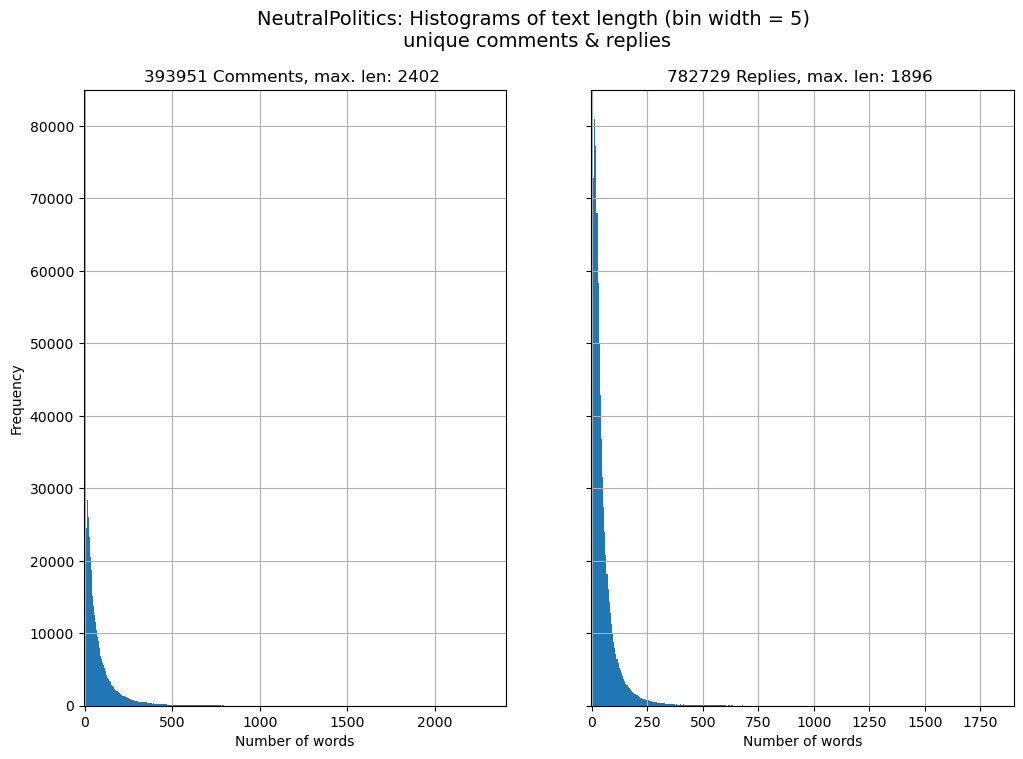

In [30]:

fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
fig.suptitle(f"{subr}: Histograms of text length (bin width = 5)\n unique comments & replies", fontsize=14)

bin_edges = np.arange(0, max(parents_all['len'].max(), 
                                  children_all['len'].max()) + 5, 5)


axes[0].hist(parents_all['len'], bins=bin_edges)
axes[0].set_xlim(-5, parents_all['len'].max() + 5)
axes[0].set_title(f"{len(parents_all)} Comments, max. len: {parents_all['len'].max()} ")
axes[0].set_xlabel("Number of words")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

axes[1].hist(children_all['len'], bins=bin_edges)
axes[1].set_xlim(-5, children_all['len'].max() + 5)
axes[1].set_title(f"{len(children_all)} Replies, max. len: {children_all['len'].max()} ")
axes[1].set_xlabel("Number of words")
axes[1].grid(True)



In [31]:
print(parents_all['len'].quantile(0.99))
print(children_all['len'].quantile(0.99))

581.0
325.0


In [26]:
parents_all

,id,body_child,len
0,c7ecs2n,Ted Olson and David Boies are extremely good ...,79
1,c7ecxpk,Just a quick note- I think they're calling it ...,52
2,c7edsp8,"is too broad, and the comments there are unli...",81
3,c7ee4yl,The mods of AskScience are incredible strict i...,29
4,c7ee63a,It's probably best explained in the rule post ...,64
...,...,...,...
45225,kafzhlv,A really good comment. I would just add from a...,131
45226,kafzpg4,Whats stopping someone from doing 350 to 1. Th...,21
45227,kahzuqu,This comment has been removed for violating co...,52
45228,ked7kd2,"I was a fan of the Obama administration, but m...",20


In [27]:
children_all

,id,body_child,len
0,c7ecs2n,Ted Olson and David Boies are extremely good ...,79
1,c7ecxpk,Just a quick note- I think they're calling it ...,52
2,c7edsp8,"is too broad, and the comments there are unli...",81
3,c7ee4yl,The mods of AskScience are incredible strict i...,29
4,c7ee63a,It's probably best explained in the rule post ...,64
...,...,...,...
45225,kafzhlv,A really good comment. I would just add from a...,131
45226,kafzpg4,Whats stopping someone from doing 350 to 1. Th...,21
45227,kahzuqu,This comment has been removed for violating co...,52
45228,ked7kd2,"I was a fan of the Obama administration, but m...",20


In [ ]:
children['len'] = children['body_child'].apply(lambda x: len(x.split()))
children

plt.

,body_child,msg_id_child,len
0,Ted Olson and David Boies are extremely good ...,c7ecs2n,79
1,Just a quick note- I think they're calling it ...,c7ecxpk,52
2,"is too broad, and the comments there are unli...",c7edsp8,81
3,The mods of AskScience are incredible strict i...,c7ee4yl,29
4,It's probably best explained in the rule post ...,c7ee63a,64
...,...,...,...
54257,That's not apples-to-apples. A better comparis...,kcank7h,72
54258,Don't Walk Run Productions is highly disingenu...,kcpthf9,7
54259,"Sounds reasonable, great write-up, kudos to you!",kd3bh9v,7
54260,"I'm not a fan of Shaprio, but all of your poin...",kd4b3a5,113
